In [1]:
!pip install  opendatasets --upgrade --quiet

In [4]:
import os
import shutil

if os.path.exists('/content/plant-village'):
  shutil.rmtree('/content/plant-village')

In [5]:
import opendatasets as od
dataset_url='https://www.kaggle.com/datasets/arjuntejaswi/plant-village'
od.download(dataset_url,force=True)

100%|██████████| 329M/329M [00:02<00:00, 121MB/s]


In [6]:
shutil.rmtree('/content/plant-village/PlantVillage/Pepper__bell___Bacterial_spot')

shutil.rmtree('/content/plant-village/PlantVillage/Pepper__bell___healthy')

shutil.rmtree('/content/plant-village/PlantVillage/Tomato_Bacterial_spot')

shutil.rmtree('/content/plant-village/PlantVillage/Tomato_Early_blight')

shutil.rmtree('/content/plant-village/PlantVillage/Tomato_Late_blight')

shutil.rmtree('/content/plant-village/PlantVillage/Tomato_Leaf_Mold')

shutil.rmtree('/content/plant-village/PlantVillage/Tomato_Septoria_leaf_spot')

shutil.rmtree('/content/plant-village/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite')
shutil.rmtree('/content/plant-village/PlantVillage/Tomato__Target_Spot')
shutil.rmtree('/content/plant-village/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus')
shutil.rmtree('/content/plant-village/PlantVillage/Tomato__Tomato_mosaic_virus')
shutil.rmtree('/content/plant-village/PlantVillage/Tomato_healthy')




In [49]:
import tensorflow as tf
from tensorflow.keras import models,layers 
import matplotlib.pyplot as plt
import numpy as np

In [8]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [9]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/plant-village/PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [10]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [11]:
len(dataset)#every element is a batch

68

In [12]:
for image_batch,label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())


(32, 256, 256, 3)
[1 1 0 1 1 0 1 1 1 0 1 0 1 1 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0]


In [13]:
for image_batch,label_batch in dataset.take(1):
  print(image_batch[0].numpy())
  print(image_batch[0].numpy().shape)
  


[[[132. 130. 144.]
  [123. 121. 135.]
  [148. 146. 160.]
  ...
  [133. 129. 144.]
  [ 92.  88. 103.]
  [105. 101. 116.]]

 [[125. 123. 137.]
  [151. 149. 163.]
  [157. 155. 169.]
  ...
  [112. 108. 123.]
  [112. 108. 123.]
  [106. 102. 117.]]

 [[ 96.  94. 108.]
  [117. 115. 129.]
  [121. 119. 133.]
  ...
  [108. 104. 119.]
  [109. 105. 120.]
  [129. 125. 140.]]

 ...

 [[171. 173. 185.]
  [176. 178. 190.]
  [182. 184. 196.]
  ...
  [155. 156. 174.]
  [157. 158. 176.]
  [157. 158. 176.]]

 [[176. 178. 190.]
  [174. 176. 188.]
  [180. 182. 194.]
  ...
  [154. 155. 173.]
  [158. 159. 177.]
  [158. 159. 177.]]

 [[179. 181. 193.]
  [167. 169. 181.]
  [173. 175. 187.]
  ...
  [156. 157. 175.]
  [160. 161. 179.]
  [162. 163. 181.]]]
(256, 256, 3)


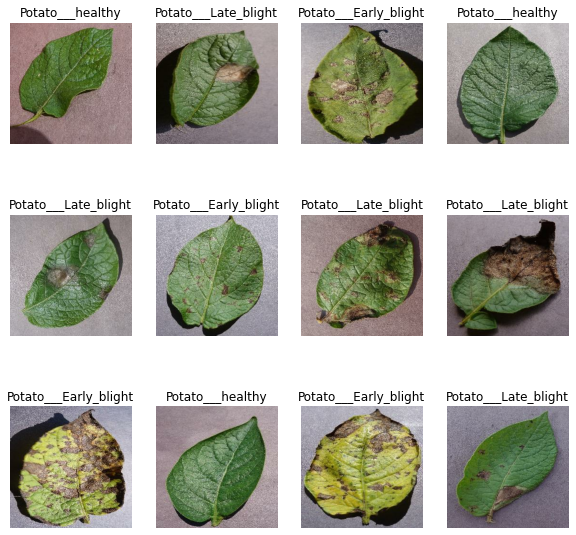

In [14]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
  for i in range(12):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

#splitting of data
10% validation
10% test
80% train

In [15]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [16]:
train_ds=dataset.take(54)
len(train_ds)

54

In [17]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [18]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [19]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [20]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [21]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [22]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [23]:
print(len(train_ds),len(val_ds),len(test_ds))


54 6 8


In [24]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

DATA SCALING and data augmentation

In [25]:
resize_and_rescale=tf.keras.Sequential([
                     layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
                     layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [26]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

MODEL LETS GO

In [27]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [31]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [32]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 19s 110ms/step - loss: 0.9159 - accuracy: 0.4659 - val_loss: 0.7962 - val_accuracy: 0.5417
Epoch 2/50
54/54 [==============================] - 4s 65ms/step - loss: 0.8223 - accuracy: 0.5978 - val_loss: 0.7082 - val_accuracy: 0.5833
Epoch 3/50
54/54 [==============================] - 3s 64ms/step - loss: 0.4513 - accuracy: 0.8108 - val_loss: 0.2835 - val_accuracy: 0.9167
Epoch 4/50
54/54 [==============================] - 3s 65ms/step - loss: 0.2909 - accuracy: 0.8802 - val_loss: 0.2691 - val_accuracy: 0.8854
Epoch 5/50
54/54 [==============================] - 3s 65ms/step - loss: 0.2320 - accuracy: 0.9097 - val_loss: 0.1344 - val_accuracy: 0.9583
Epoch 6/50
54/54 [==============================] - 4s 65ms/step - loss: 0.1785 - accuracy: 0.9300 - val_loss: 0.1464 - val_accuracy: 0.9583
Epoch 7/50
54/54 [==============================] - 4s 72ms/step - loss: 0.1301 - accuracy: 0.9508 - val_loss: 0.1594 - val_accuracy: 0.9479
Epoch 8/50


In [33]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 2s 32ms/step - loss: 3.4709e-04 - accuracy: 1.0000


In [34]:
scores

[0.00034709039027802646, 1.0]

In [37]:
print(history)
print(history.params)
print(history.history.keys())
print(history.history['accuracy'])


{'verbose': 1, 'epochs': 50, 'steps': 54}
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
[0.46585649251937866, 0.5978009104728699, 0.8107638955116272, 0.8802083134651184, 0.9097222089767456, 0.9299768805503845, 0.9508101940155029, 0.9565972089767456, 0.9479166865348816, 0.9704861044883728, 0.9774305820465088, 0.9728009104728699, 0.96875, 0.9791666865348816, 0.9895833134651184, 0.9745370149612427, 0.9913194179534912, 0.9930555820465088, 0.9930555820465088, 0.9930555820465088, 0.9930555820465088, 0.9994212985038757, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [36]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']


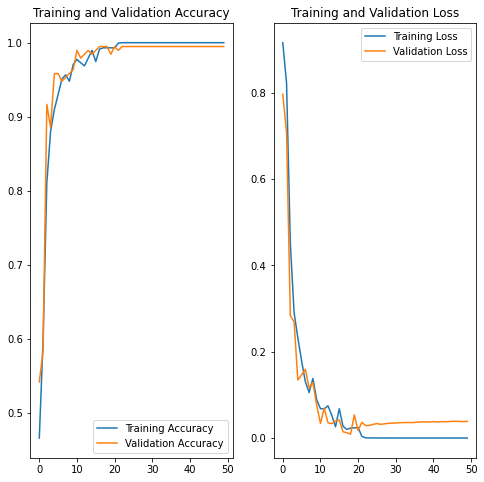

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

OUTPUT LETS GO

actual= Potato___Late_blight
pred= Potato___Late_blight


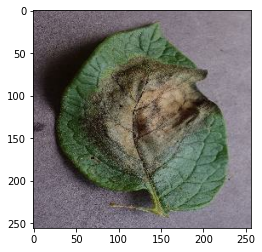

In [53]:
for images_batch,labels_batch in test_ds.take(1):
  plt.imshow(images_batch[0].numpy().astype('uint8'))
  print("actual=",class_names[labels_batch[0]])

  pred=model.predict(images_batch)
  print("pred=",class_names[np.argmax(pred[0])])

In [54]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

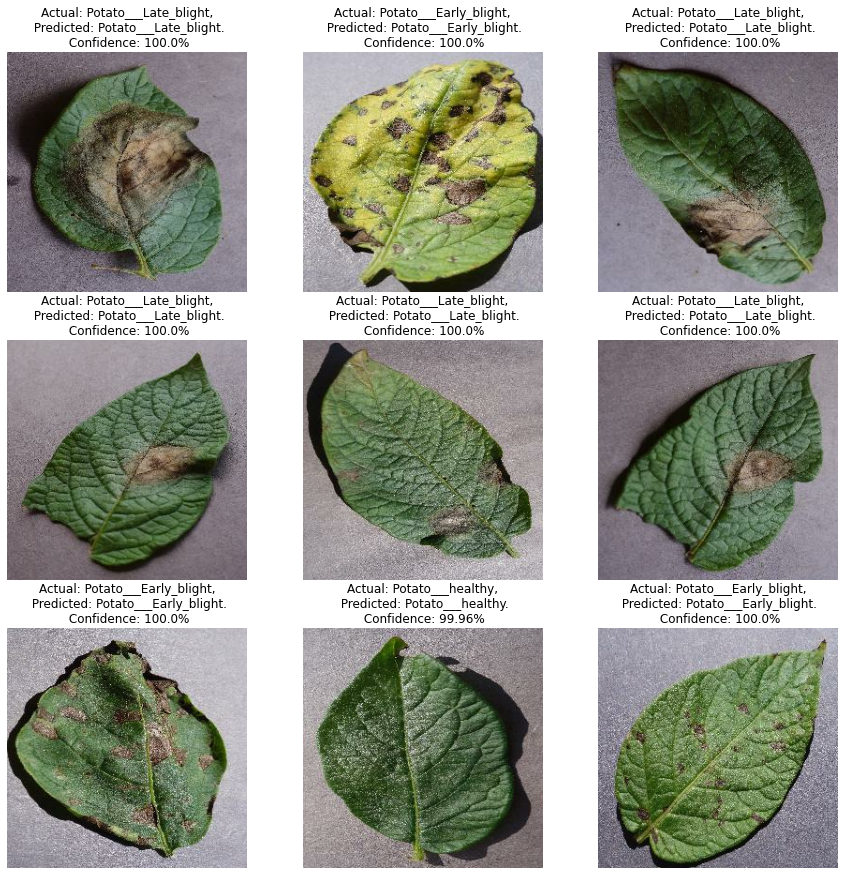

In [55]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")